In [14]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.densenet import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

CLASS_NAMES = ["No Finding", "Pneumonia", "Other Diseases"]
mlb = MultiLabelBinarizer(classes=CLASS_NAMES)

# Load CSV
train_df = pd.read_csv("D:\\xray file\\vindr-pcxr-an-open-large-scale-pediatric-chest-x-ray-dataset-for-interpretation-of-common-thoracic-diseases-1.0.0\\image_labels_train.csv")

# Define the labels you're interested in
CLASS_NAMES = ["No finding", "Pneumonia", "Other disease"]

# Keep only image_id and those class columns
train_df = train_df[["image_id"] + CLASS_NAMES]

# Remove rows where all class labels are 0 (i.e., no relevant condition present)
train_df = train_df[train_df[CLASS_NAMES].sum(axis=1) > 0]

# No need to encode anything – the labels are already in multi-hot format
# You can directly use: train_df[CLASS_NAMES].values for labels
# Oversample Pneumonia and Other disease
minority_df = train_df[(train_df["Pneumonia"] == 1) | (train_df["Other disease"] == 1)]
train_df = pd.concat([train_df, minority_df, minority_df], ignore_index=True).sample(frac=1).reset_index(drop=True)

path='D:\\xray file\\vindr-pcxr-an-open-large-scale-pediatric-chest-x-ray-dataset-for-interpretation-of-common-thoracic-diseases-1.0.0\\train'
def load_dicom_image(path, img_size=(224, 224)):
    dicom = pydicom.dcmread(path)
    img = apply_voi_lut(dicom.pixel_array, dicom)
    img = img.astype(np.float32)
    img = (img - np.min(img)) / (np.max(img) - np.min(img))
    img = np.stack([img] * 3, axis=-1)  # Convert to 3-channel
    img = tf.image.resize(img, img_size)
    img = preprocess_input(img)
    return img

def create_dataset(df, base_dir, batch_size=8, shuffle=True):
    paths = df['image_id'].apply(lambda x: os.path.join(base_dir, f"{x}.dicom")).values
    labels = df[CLASS_NAMES].values.astype(np.float32)  # ✅ Use actual class columns

    def gen():
        for path, label in zip(paths, labels):
            try:
                img = load_dicom_image(path)
                yield img, label
            except:
                continue  # Skip unreadable or missing files

    dataset = tf.data.Dataset.from_generator(
        gen,
        output_signature=(
            tf.TensorSpec(shape=(224, 224, 3), dtype=tf.float32),
            tf.TensorSpec(shape=(len(CLASS_NAMES),), dtype=tf.float32)
        )
    )
    if shuffle:
        dataset = dataset.shuffle(1024)
    return dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

from sklearn.utils import resample

# Step 1: Extract the subsets (multi-label allowed)
no_finding_df = train_df[train_df["No finding"] == 1]
pneumonia_df = train_df[train_df["Pneumonia"] == 1]
other_disease_df = train_df[train_df["Other disease"] == 1]

# Step 2: Oversample PNEUMONIA and OTHER only — DON'T touch No Finding
target_count = max(len(pneumonia_df), len(other_disease_df))

pneumonia_upsampled = resample(pneumonia_df, 
                                replace=True, 
                                n_samples=target_count, 
                                random_state=42)

other_upsampled = resample(other_disease_df, 
                           replace=True, 
                           n_samples=target_count, 
                           random_state=42)

# Step 3: Combine everything (oversampled + original no finding)
balanced_df = pd.concat([no_finding_df, pneumonia_upsampled, other_upsampled])
balanced_df = balanced_df.drop_duplicates(subset='image_id')  # remove exact duplicates
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)  # shuffle

# Step 4: Show new distribution
print("✅ Final balanced image count per class:")
print(balanced_df[["No finding", "Pneumonia", "Other disease"]].sum().astype(int))

target_count = max(len(no_finding_df), len(pneumonia_df), len(other_disease_df))
# Then resample all 3 to this count

# Convert multi-label binary columns into tuples for stratification
train_df['label_tuple'] = train_df[CLASS_NAMES].apply(lambda row: tuple(row.astype(int)), axis=1)

# Perform the split
train_data, val_data = train_test_split(
    train_df,
    test_size=0.2,
    stratify=train_df['label_tuple'],
    random_state=42
)

# Optional: Drop the helper column
train_data = train_data.drop(columns=["label_tuple"])
val_data = val_data.drop(columns=["label_tuple"])

# Count number of images where each class is labeled as 1
class_counts = train_df[["No finding", "Pneumonia", "Other disease"]].sum().astype(int)

print("✅ Number of images per class:")
print(class_counts)


def weighted_sigmoid_focal_loss(class_weights, gamma=2.0):
    def loss_fn(y_true, y_pred):
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1.0 - 1e-7)
        loss = - y_true * tf.pow(1 - y_pred, gamma) * tf.math.log(y_pred)
        loss -= (1 - y_true) * tf.pow(y_pred, gamma) * tf.math.log(1 - y_pred)
        
        weights = tf.constant([class_weights[i] for i in range(len(class_weights))], dtype=tf.float32)
        loss *= weights
        return tf.reduce_mean(loss)
    return loss_fn
class_totals = train_df[["No finding", "Pneumonia", "Other disease"]].sum()
total_samples = len(train_df)
class_weights = {
    0: total_samples / (3 * class_totals["No finding"]),
    1: total_samples / (3 * class_totals["Pneumonia"]),
    2: total_samples / (3 * class_totals["Other disease"]),
}


print("Class weights:", class_weights)

from tensorflow.keras.layers import Dropout
base_model = DenseNet121(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = False
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
output = Dense(len(CLASS_NAMES), activation='sigmoid')(x)
model = Model(inputs=base_model.input, outputs=output)

# pip install keras-losses (if not already done)



from focal_loss import SparseCategoricalFocalLoss
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
   loss=weighted_sigmoid_focal_loss(class_weights, gamma=2.0),

    metrics=[
        'accuracy',
        tf.keras.metrics.AUC(name='auc'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
)


# model.summary()

train_dataset = create_dataset(train_data, base_dir=path)
val_dataset = create_dataset(val_data, base_dir=path, shuffle=False)

batch_size = 8

train_dataset = train_dataset.repeat()
val_dataset = val_dataset.repeat()
# train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)
# val_dataset = val_dataset.prefetch(tf.data.AUTOTUNE)

steps_per_epoch = len(train_data) // batch_size
validation_steps = len(val_data) // batch_size

callbacks = [
    EarlyStopping(monitor="val_auc", patience=5, mode="max", restore_best_weights=True),
    ModelCheckpoint("best_model.keras", save_best_only=True)
]

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    epochs=10,
    callbacks=callbacks
)


✅ Final balanced image count per class:
No finding       5143
Pneumonia         376
Other disease     397
dtype: int64
✅ Number of images per class:
No finding       5143
Pneumonia        1176
Other disease    1236
dtype: int64
Class weights: {0: np.float64(0.48344027480718127), 1: np.float64(2.1142290249433104), 2: np.float64(2.011596548004315)}
Epoch 1/10
745/745 ━━━━━━━━━━━━━━━━━━━━ 2541s 3s/step - accuracy: 0.3924 - auc: 0.5289 - loss: 0.2865 - precision: 0.4291 - recall: 0.2832 - val_accuracy: 0.6895 - val_auc: 0.7599 - val_loss: 0.1850 - val_precision: 0.6895 - val_recall: 0.6808
Epoch 2/10
745/745 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6518 - auc: 0.7443 - loss: 0.2142 - precision: 0.6482 - recall: 0.5504

Exception ignored in: <generator object create_dataset.<locals>.gen at 0x000001C3C050DC40>
Traceback (most recent call last):
  File "C:\Users\bisma\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tensorflow\python\data\ops\dataset_ops.py", line 872, in iterator_completed
    del self._iterators[self._normalize_id(iterator_id)]
        ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
RuntimeError: generator ignored GeneratorExit


745/745 ━━━━━━━━━━━━━━━━━━━━ 2245s 3s/step - accuracy: 0.6518 - auc: 0.7443 - loss: 0.2142 - precision: 0.6482 - recall: 0.5504 - val_accuracy: 0.6895 - val_auc: 0.7682 - val_loss: 0.1857 - val_precision: 0.6895 - val_recall: 0.6808
Epoch 3/10
745/745 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6758 - auc: 0.7615 - loss: 0.2013 - precision: 0.6798 - recall: 0.5865

Exception ignored in: <generator object create_dataset.<locals>.gen at 0x000001C3C050E040>
Traceback (most recent call last):
  File "C:\Users\bisma\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tensorflow\python\data\ops\dataset_ops.py", line 872, in iterator_completed
    del self._iterators[self._normalize_id(iterator_id)]
        ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
RuntimeError: generator ignored GeneratorExit


745/745 ━━━━━━━━━━━━━━━━━━━━ 2215s 3s/step - accuracy: 0.6758 - auc: 0.7615 - loss: 0.2013 - precision: 0.6798 - recall: 0.5865 - val_accuracy: 0.6895 - val_auc: 0.7700 - val_loss: 0.1858 - val_precision: 0.6895 - val_recall: 0.6808
Epoch 4/10
745/745 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6863 - auc: 0.7664 - loss: 0.1964 - precision: 0.6935 - recall: 0.6252

Exception ignored in: <generator object create_dataset.<locals>.gen at 0x000001C3C050DC40>
Traceback (most recent call last):
  File "C:\Users\bisma\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tensorflow\python\data\ops\dataset_ops.py", line 872, in iterator_completed
    del self._iterators[self._normalize_id(iterator_id)]
        ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
RuntimeError: generator ignored GeneratorExit


745/745 ━━━━━━━━━━━━━━━━━━━━ 2260s 3s/step - accuracy: 0.6863 - auc: 0.7664 - loss: 0.1964 - precision: 0.6935 - recall: 0.6252 - val_accuracy: 0.6895 - val_auc: 0.7776 - val_loss: 0.1844 - val_precision: 0.6895 - val_recall: 0.6808
Epoch 5/10
745/745 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6835 - auc: 0.7642 - loss: 0.1945 - precision: 0.6845 - recall: 0.6201

Exception ignored in: <generator object create_dataset.<locals>.gen at 0x000001C3C050D440>
Traceback (most recent call last):
  File "C:\Users\bisma\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tensorflow\python\data\ops\dataset_ops.py", line 872, in iterator_completed
    del self._iterators[self._normalize_id(iterator_id)]
        ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
RuntimeError: generator ignored GeneratorExit


745/745 ━━━━━━━━━━━━━━━━━━━━ 2254s 3s/step - accuracy: 0.6835 - auc: 0.7642 - loss: 0.1945 - precision: 0.6845 - recall: 0.6201 - val_accuracy: 0.6895 - val_auc: 0.7734 - val_loss: 0.1847 - val_precision: 0.6895 - val_recall: 0.6808
Epoch 6/10
745/745 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6913 - auc: 0.7643 - loss: 0.1931 - precision: 0.6897 - recall: 0.6416

Exception ignored in: <generator object create_dataset.<locals>.gen at 0x000001C3C050E640>
Traceback (most recent call last):
  File "C:\Users\bisma\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tensorflow\python\data\ops\dataset_ops.py", line 872, in iterator_completed
    del self._iterators[self._normalize_id(iterator_id)]
        ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
RuntimeError: generator ignored GeneratorExit


745/745 ━━━━━━━━━━━━━━━━━━━━ 2231s 3s/step - accuracy: 0.6913 - auc: 0.7643 - loss: 0.1931 - precision: 0.6897 - recall: 0.6416 - val_accuracy: 0.6895 - val_auc: 0.7768 - val_loss: 0.1850 - val_precision: 0.6895 - val_recall: 0.6808
Epoch 7/10
745/745 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6901 - auc: 0.7635 - loss: 0.1910 - precision: 0.6899 - recall: 0.6467

Exception ignored in: <generator object create_dataset.<locals>.gen at 0x000001C3C050D240>
Traceback (most recent call last):
  File "C:\Users\bisma\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tensorflow\python\data\ops\dataset_ops.py", line 872, in iterator_completed
    del self._iterators[self._normalize_id(iterator_id)]
        ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
RuntimeError: generator ignored GeneratorExit


745/745 ━━━━━━━━━━━━━━━━━━━━ 2216s 3s/step - accuracy: 0.6901 - auc: 0.7635 - loss: 0.1910 - precision: 0.6899 - recall: 0.6467 - val_accuracy: 0.6895 - val_auc: 0.7819 - val_loss: 0.1843 - val_precision: 0.6895 - val_recall: 0.6808
Epoch 8/10
745/745 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6964 - auc: 0.7686 - loss: 0.1878 - precision: 0.6971 - recall: 0.6735

Exception ignored in: <generator object create_dataset.<locals>.gen at 0x000001C3C050E640>
Traceback (most recent call last):
  File "C:\Users\bisma\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tensorflow\python\data\ops\dataset_ops.py", line 872, in iterator_completed
    del self._iterators[self._normalize_id(iterator_id)]
        ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
RuntimeError: generator ignored GeneratorExit


745/745 ━━━━━━━━━━━━━━━━━━━━ 2141s 3s/step - accuracy: 0.6964 - auc: 0.7686 - loss: 0.1878 - precision: 0.6971 - recall: 0.6735 - val_accuracy: 0.6895 - val_auc: 0.7872 - val_loss: 0.1839 - val_precision: 0.6895 - val_recall: 0.6808
Epoch 9/10
745/745 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6874 - auc: 0.7661 - loss: 0.1883 - precision: 0.6870 - recall: 0.6630

Exception ignored in: <generator object create_dataset.<locals>.gen at 0x000001C3C050D740>
Traceback (most recent call last):
  File "C:\Users\bisma\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tensorflow\python\data\ops\dataset_ops.py", line 872, in iterator_completed
    del self._iterators[self._normalize_id(iterator_id)]
        ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
RuntimeError: generator ignored GeneratorExit


745/745 ━━━━━━━━━━━━━━━━━━━━ 2103s 3s/step - accuracy: 0.6874 - auc: 0.7661 - loss: 0.1883 - precision: 0.6870 - recall: 0.6630 - val_accuracy: 0.6895 - val_auc: 0.7878 - val_loss: 0.1839 - val_precision: 0.6895 - val_recall: 0.6808
Epoch 10/10
745/745 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6944 - auc: 0.7691 - loss: 0.1864 - precision: 0.6946 - recall: 0.6764

Exception ignored in: <generator object create_dataset.<locals>.gen at 0x000001C3C050D240>
Traceback (most recent call last):
  File "C:\Users\bisma\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tensorflow\python\data\ops\dataset_ops.py", line 872, in iterator_completed
    del self._iterators[self._normalize_id(iterator_id)]
        ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
RuntimeError: generator ignored GeneratorExit


745/745 ━━━━━━━━━━━━━━━━━━━━ 2177s 3s/step - accuracy: 0.6944 - auc: 0.7691 - loss: 0.1864 - precision: 0.6946 - recall: 0.6764 - val_accuracy: 0.6895 - val_auc: 0.7960 - val_loss: 0.1835 - val_precision: 0.6895 - val_recall: 0.6808


Exception ignored in: <generator object create_dataset.<locals>.gen at 0x000001C3C050D440>
Traceback (most recent call last):
  File "C:\Users\bisma\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tensorflow\python\data\ops\dataset_ops.py", line 872, in iterator_completed
    del self._iterators[self._normalize_id(iterator_id)]
        ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
RuntimeError: generator ignored GeneratorExit
Exception ignored in: <generator object create_dataset.<locals>.gen at 0x000001C3C050E040>
Traceback (most recent call last):
  File "C:\Users\bisma\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tensorflow\python\data\ops\dataset_ops.py", line 872, in iterator_completed
    del self._iterators[self._normalize_id(iterator_id)]
        ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
RuntimeError: generator igno

In [16]:
callbacks1 = [
    EarlyStopping(monitor="val_auc", patience=5, mode="max", restore_best_weights=True),
    ModelCheckpoint("best_model.keras", save_best_only=True),
    tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_auc',
    factor=0.5,
    patience=2,
    min_lr=1e-7,
    verbose=1
)
] 
 #🔓 Unfreeze last 30 layers of base model
base_model.trainable = True
for layer in base_model.layers[:-30]:
    layer.trainable = False

# Recompile with a smaller LR


model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
   loss=weighted_sigmoid_focal_loss(class_weights, gamma=2.0),

    metrics=[
        'accuracy',
        tf.keras.metrics.AUC(name='auc'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.TruePositives(name='tp'),
        tf.keras.metrics.FalsePositives(name='fp'),
        tf.keras.metrics.TrueNegatives(name='tn'),
        tf.keras.metrics.FalseNegatives(name='fn')
    ]
)


# Continue training
history_finetune_30 = model.fit(
    train_dataset,
    validation_data=val_dataset,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    epochs=10,
    callbacks=callbacks1
)

Epoch 1/10
745/745 ━━━━━━━━━━━━━━━━━━━━ 2851s 3s/step - accuracy: 0.6336 - auc: 0.7410 - fn: 1331.9384 - fp: 1048.1407 - loss: 0.5577 - precision: 0.6181 - recall: 0.5758 - tn: 4890.7827 - tp: 1693.1060 - val_accuracy: 0.6888 - val_auc: 0.7895 - val_fn: 483.0000 - val_fp: 457.0000 - val_loss: 0.2681 - val_precision: 0.6914 - val_recall: 0.6795 - val_tn: 2500.0000 - val_tp: 1024.0000 - learning_rate: 1.0000e-05
Epoch 2/10
745/745 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5970 - auc: 0.7250 - fn: 1459.6429 - fp: 1108.8792 - loss: 0.3305 - precision: 0.5904 - recall: 0.5159 - tn: 4817.4429 - tp: 1563.0349

Exception ignored in: <generator object create_dataset.<locals>.gen at 0x000001C3FF53B840>
Traceback (most recent call last):
  File "C:\Users\bisma\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tensorflow\python\data\ops\dataset_ops.py", line 872, in iterator_completed
    del self._iterators[self._normalize_id(iterator_id)]
        ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
RuntimeError: generator ignored GeneratorExit


745/745 ━━━━━━━━━━━━━━━━━━━━ 2540s 3s/step - accuracy: 0.5970 - auc: 0.7250 - fn: 1461.5442 - fp: 1110.5067 - loss: 0.3305 - precision: 0.5904 - recall: 0.5159 - tn: 4823.7427 - tp: 1565.1743 - val_accuracy: 0.6888 - val_auc: 0.8121 - val_fn: 487.0000 - val_fp: 454.0000 - val_loss: 0.1961 - val_precision: 0.6920 - val_recall: 0.6768 - val_tn: 2503.0000 - val_tp: 1020.0000 - learning_rate: 1.0000e-05
Epoch 3/10
745/745 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5764 - auc: 0.7065 - fn: 1437.0470 - fp: 1283.7034 - loss: 0.3038 - precision: 0.5522 - recall: 0.5234 - tn: 4646.4307 - tp: 1581.8229

Exception ignored in: <generator object create_dataset.<locals>.gen at 0x000001C3FF53B840>
Traceback (most recent call last):
  File "C:\Users\bisma\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tensorflow\python\data\ops\dataset_ops.py", line 872, in iterator_completed
    del self._iterators[self._normalize_id(iterator_id)]
        ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
RuntimeError: generator ignored GeneratorExit



Epoch 3: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.
745/745 ━━━━━━━━━━━━━━━━━━━━ 1653s 2s/step - accuracy: 0.5764 - auc: 0.7065 - fn: 1438.9625 - fp: 1285.4410 - loss: 0.3038 - precision: 0.5522 - recall: 0.5234 - tn: 4652.6167 - tp: 1583.9518 - val_accuracy: 0.6895 - val_auc: 0.8176 - val_fn: 488.0000 - val_fp: 451.0000 - val_loss: 0.1930 - val_precision: 0.6932 - val_recall: 0.6762 - val_tn: 2506.0000 - val_tp: 1019.0000 - learning_rate: 1.0000e-05
Epoch 4/10
745/745 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5893 - auc: 0.7192 - fn: 1395.8577 - fp: 1229.7611 - loss: 0.2981 - precision: 0.5720 - recall: 0.5406 - tn: 4698.0215 - tp: 1625.3678

Exception ignored in: <generator object create_dataset.<locals>.gen at 0x000001C3FF53B940>
Traceback (most recent call last):
  File "C:\Users\bisma\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tensorflow\python\data\ops\dataset_ops.py", line 872, in iterator_completed
    del self._iterators[self._normalize_id(iterator_id)]
        ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
RuntimeError: generator ignored GeneratorExit


745/745 ━━━━━━━━━━━━━━━━━━━━ 2028s 3s/step - accuracy: 0.5893 - auc: 0.7192 - fn: 1397.7600 - fp: 1231.4545 - loss: 0.2981 - precision: 0.5719 - recall: 0.5406 - tn: 4704.2549 - tp: 1627.5067 - val_accuracy: 0.6888 - val_auc: 0.8190 - val_fn: 484.0000 - val_fp: 455.0000 - val_loss: 0.1920 - val_precision: 0.6922 - val_recall: 0.6788 - val_tn: 2502.0000 - val_tp: 1023.0000 - learning_rate: 5.0000e-06
Epoch 5/10
745/745 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5858 - auc: 0.7101 - fn: 1414.2563 - fp: 1272.4094 - loss: 0.2995 - precision: 0.5605 - recall: 0.5325 - tn: 4657.5649 - tp: 1604.7812

Exception ignored in: <generator object create_dataset.<locals>.gen at 0x000001C3FF53B940>
Traceback (most recent call last):
  File "C:\Users\bisma\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tensorflow\python\data\ops\dataset_ops.py", line 872, in iterator_completed
    del self._iterators[self._normalize_id(iterator_id)]
        ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
RuntimeError: generator ignored GeneratorExit



Epoch 5: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-06.
745/745 ━━━━━━━━━━━━━━━━━━━━ 2465s 3s/step - accuracy: 0.5858 - auc: 0.7101 - fn: 1416.1246 - fp: 1274.1152 - loss: 0.2995 - precision: 0.5605 - recall: 0.5325 - tn: 4663.7827 - tp: 1606.9572 - val_accuracy: 0.6902 - val_auc: 0.8207 - val_fn: 487.0000 - val_fp: 451.0000 - val_loss: 0.1898 - val_precision: 0.6934 - val_recall: 0.6768 - val_tn: 2506.0000 - val_tp: 1020.0000 - learning_rate: 5.0000e-06
Epoch 6/10
745/745 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5840 - auc: 0.7192 - fn: 1389.1061 - fp: 1277.1744 - loss: 0.2969 - precision: 0.5605 - recall: 0.5442 - tn: 4653.4307 - tp: 1629.3047

Exception ignored in: <generator object create_dataset.<locals>.gen at 0x000001C3FF53B840>
Traceback (most recent call last):
  File "C:\Users\bisma\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tensorflow\python\data\ops\dataset_ops.py", line 872, in iterator_completed
    del self._iterators[self._normalize_id(iterator_id)]
        ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
RuntimeError: generator ignored GeneratorExit


745/745 ━━━━━━━━━━━━━━━━━━━━ 2005s 3s/step - accuracy: 0.5840 - auc: 0.7192 - fn: 1391.0040 - fp: 1278.8821 - loss: 0.2969 - precision: 0.5605 - recall: 0.5442 - tn: 4659.6475 - tp: 1631.4504 - val_accuracy: 0.6902 - val_auc: 0.8213 - val_fn: 489.0000 - val_fp: 451.0000 - val_loss: 0.1888 - val_precision: 0.6930 - val_recall: 0.6755 - val_tn: 2506.0000 - val_tp: 1018.0000 - learning_rate: 2.5000e-06
Epoch 7/10
745/745 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5804 - auc: 0.7100 - fn: 1402.4484 - fp: 1308.6134 - loss: 0.2980 - precision: 0.5527 - recall: 0.5362 - tn: 4620.1235 - tp: 1617.8348

Exception ignored in: <generator object create_dataset.<locals>.gen at 0x000001C3FF53B440>
Traceback (most recent call last):
  File "C:\Users\bisma\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tensorflow\python\data\ops\dataset_ops.py", line 872, in iterator_completed
    del self._iterators[self._normalize_id(iterator_id)]
        ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
RuntimeError: generator ignored GeneratorExit



Epoch 7: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-06.
745/745 ━━━━━━━━━━━━━━━━━━━━ 2328s 3s/step - accuracy: 0.5804 - auc: 0.7100 - fn: 1404.3337 - fp: 1310.3512 - loss: 0.2980 - precision: 0.5527 - recall: 0.5362 - tn: 4626.3096 - tp: 1619.9933 - val_accuracy: 0.6902 - val_auc: 0.8220 - val_fn: 488.0000 - val_fp: 449.0000 - val_loss: 0.1893 - val_precision: 0.6941 - val_recall: 0.6762 - val_tn: 2508.0000 - val_tp: 1019.0000 - learning_rate: 2.5000e-06
Epoch 8/10
745/745 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5898 - auc: 0.7198 - fn: 1397.6429 - fp: 1280.3436 - loss: 0.2871 - precision: 0.5577 - recall: 0.5358 - tn: 4652.3999 - tp: 1618.6376

Exception ignored in: <generator object create_dataset.<locals>.gen at 0x000001C3FF53B440>
Traceback (most recent call last):
  File "C:\Users\bisma\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tensorflow\python\data\ops\dataset_ops.py", line 872, in iterator_completed
    del self._iterators[self._normalize_id(iterator_id)]
        ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
RuntimeError: generator ignored GeneratorExit


745/745 ━━━━━━━━━━━━━━━━━━━━ 1410s 2s/step - accuracy: 0.5898 - auc: 0.7198 - fn: 1399.5242 - fp: 1282.0630 - loss: 0.2871 - precision: 0.5577 - recall: 0.5358 - tn: 4658.6030 - tp: 1620.8016 - val_accuracy: 0.6902 - val_auc: 0.8220 - val_fn: 489.0000 - val_fp: 450.0000 - val_loss: 0.1880 - val_precision: 0.6935 - val_recall: 0.6755 - val_tn: 2507.0000 - val_tp: 1018.0000 - learning_rate: 1.2500e-06
Epoch 9/10
745/745 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5864 - auc: 0.7171 - fn: 1416.5865 - fp: 1256.7141 - loss: 0.2898 - precision: 0.5652 - recall: 0.5278 - tn: 4670.7935 - tp: 1604.9342

Exception ignored in: <generator object create_dataset.<locals>.gen at 0x000001C3FF53B540>
Traceback (most recent call last):
  File "C:\Users\bisma\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tensorflow\python\data\ops\dataset_ops.py", line 872, in iterator_completed
    del self._iterators[self._normalize_id(iterator_id)]
        ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
RuntimeError: generator ignored GeneratorExit



Epoch 9: ReduceLROnPlateau reducing learning rate to 6.24999984211172e-07.
745/745 ━━━━━━━━━━━━━━━━━━━━ 1394s 2s/step - accuracy: 0.5864 - auc: 0.7171 - fn: 1418.4572 - fp: 1258.4115 - loss: 0.2898 - precision: 0.5652 - recall: 0.5278 - tn: 4677.0200 - tp: 1607.1072 - val_accuracy: 0.6902 - val_auc: 0.8221 - val_fn: 487.0000 - val_fp: 449.0000 - val_loss: 0.1879 - val_precision: 0.6943 - val_recall: 0.6768 - val_tn: 2508.0000 - val_tp: 1020.0000 - learning_rate: 1.2500e-06
Epoch 10/10
745/745 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5702 - auc: 0.7052 - fn: 1422.9194 - fp: 1312.5892 - loss: 0.3010 - precision: 0.5399 - recall: 0.5219 - tn: 4617.9395 - tp: 1595.5839

Exception ignored in: <generator object create_dataset.<locals>.gen at 0x000001C3FF53B840>
Traceback (most recent call last):
  File "C:\Users\bisma\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tensorflow\python\data\ops\dataset_ops.py", line 872, in iterator_completed
    del self._iterators[self._normalize_id(iterator_id)]
        ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
RuntimeError: generator ignored GeneratorExit


745/745 ━━━━━━━━━━━━━━━━━━━━ 1386s 2s/step - accuracy: 0.5702 - auc: 0.7052 - fn: 1424.7842 - fp: 1314.2922 - loss: 0.3010 - precision: 0.5399 - recall: 0.5219 - tn: 4624.1636 - tp: 1597.7600 - val_accuracy: 0.6902 - val_auc: 0.8226 - val_fn: 487.0000 - val_fp: 449.0000 - val_loss: 0.1881 - val_precision: 0.6943 - val_recall: 0.6768 - val_tn: 2508.0000 - val_tp: 1020.0000 - learning_rate: 6.2500e-07


Exception ignored in: <generator object create_dataset.<locals>.gen at 0x000001C3FF53B240>
Traceback (most recent call last):
  File "C:\Users\bisma\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tensorflow\python\data\ops\dataset_ops.py", line 872, in iterator_completed
    del self._iterators[self._normalize_id(iterator_id)]
        ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
RuntimeError: generator ignored GeneratorExit


In [18]:
model.save("xray_densenet_model.keras")  # No file extension needed
print("✅ Model saved as TensorFlow SavedModel in 'xray_mobilenet_model' directory")

✅ Model saved as TensorFlow SavedModel in 'xray_mobilenet_model' directory


In [19]:
# 🔓 Unfreeze all layers
for layer in base_model.layers:
    layer.trainable = True



model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
   loss=weighted_sigmoid_focal_loss(class_weights, gamma=2.0),

    metrics=[
        'accuracy',
        tf.keras.metrics.AUC(name='auc'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.TruePositives(name='tp'),
        tf.keras.metrics.FalsePositives(name='fp'),
        tf.keras.metrics.TrueNegatives(name='tn'),
        tf.keras.metrics.FalseNegatives(name='fn')
    ]
)

# Final training phase
history_finetune_all = model.fit(
    train_dataset,
    validation_data=val_dataset,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    epochs=10,
    callbacks=callbacks1
)

Epoch 1/10
745/745 ━━━━━━━━━━━━━━━━━━━━ 3628s 4s/step - accuracy: 0.5633 - auc: 0.7058 - fn: 1435.8848 - fp: 1320.8848 - loss: 0.3651 - precision: 0.5366 - recall: 0.5097 - tn: 4618.5186 - tp: 1588.6796 - val_accuracy: 0.1586 - val_auc: 0.2619 - val_fn: 1222.0000 - val_fp: 1421.0000 - val_loss: 0.3673 - val_precision: 0.1671 - val_recall: 0.1891 - val_tn: 1536.0000 - val_tp: 285.0000 - learning_rate: 1.0000e-05
Epoch 2/10
745/745 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6110 - auc: 0.7496 - fn: 1261.2899 - fp: 1230.1691 - loss: 0.2950 - precision: 0.5797 - recall: 0.5773 - tn: 4698.4282 - tp: 1759.1128

Exception ignored in: <generator object create_dataset.<locals>.gen at 0x000001C3FF53AF40>
Traceback (most recent call last):
  File "C:\Users\bisma\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tensorflow\python\data\ops\dataset_ops.py", line 872, in iterator_completed
    del self._iterators[self._normalize_id(iterator_id)]
        ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
RuntimeError: generator ignored GeneratorExit


745/745 ━━━━━━━━━━━━━━━━━━━━ 2720s 4s/step - accuracy: 0.6110 - auc: 0.7496 - fn: 1262.9664 - fp: 1231.7654 - loss: 0.2950 - precision: 0.5797 - recall: 0.5773 - tn: 4704.7573 - tp: 1761.4785 - val_accuracy: 0.6196 - val_auc: 0.7490 - val_fn: 1506.0000 - val_fp: 1.0000 - val_loss: 0.2572 - val_precision: 0.5000 - val_recall: 6.6357e-04 - val_tn: 2956.0000 - val_tp: 1.0000 - learning_rate: 1.0000e-05
Epoch 3/10
745/745 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6649 - auc: 0.7981 - fn: 1173.9557 - fp: 1080.6550 - loss: 0.2402 - precision: 0.6319 - recall: 0.6109 - tn: 4847.5181 - tp: 1846.8751

Exception ignored in: <generator object create_dataset.<locals>.gen at 0x000001C3FF53AF40>
Traceback (most recent call last):
  File "C:\Users\bisma\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tensorflow\python\data\ops\dataset_ops.py", line 872, in iterator_completed
    del self._iterators[self._normalize_id(iterator_id)]
        ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
RuntimeError: generator ignored GeneratorExit



Epoch 3: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.
745/745 ━━━━━━━━━━━━━━━━━━━━ 2307s 3s/step - accuracy: 0.6649 - auc: 0.7981 - fn: 1175.4933 - fp: 1082.0912 - loss: 0.2402 - precision: 0.6319 - recall: 0.6109 - tn: 4854.0078 - tp: 1849.3794 - val_accuracy: 0.1935 - val_auc: 0.4553 - val_fn: 1341.0000 - val_fp: 686.0000 - val_loss: 0.2802 - val_precision: 0.1948 - val_recall: 0.1102 - val_tn: 2271.0000 - val_tp: 166.0000 - learning_rate: 1.0000e-05
Epoch 4/10
745/745 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6886 - auc: 0.8339 - fn: 1038.3665 - fp: 950.0054 - loss: 0.2092 - precision: 0.6702 - recall: 0.6511 - tn: 4978.7827 - tp: 1981.8536

Exception ignored in: <generator object create_dataset.<locals>.gen at 0x000001C3FF53B740>
Traceback (most recent call last):
  File "C:\Users\bisma\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tensorflow\python\data\ops\dataset_ops.py", line 872, in iterator_completed
    del self._iterators[self._normalize_id(iterator_id)]
        ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
RuntimeError: generator ignored GeneratorExit


745/745 ━━━━━━━━━━━━━━━━━━━━ 2120s 3s/step - accuracy: 0.6886 - auc: 0.8340 - fn: 1039.7333 - fp: 951.2413 - loss: 0.2092 - precision: 0.6702 - recall: 0.6511 - tn: 4985.4717 - tp: 1984.5295 - val_accuracy: 0.3535 - val_auc: 0.5227 - val_fn: 1260.0000 - val_fp: 423.0000 - val_loss: 0.2347 - val_precision: 0.3687 - val_recall: 0.1639 - val_tn: 2534.0000 - val_tp: 247.0000 - learning_rate: 5.0000e-06
Epoch 5/10
745/745 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7400 - auc: 0.8716 - fn: 925.1060 - fp: 866.8765 - loss: 0.1747 - precision: 0.7036 - recall: 0.6915 - tn: 5061.2510 - tp: 2095.7786

Exception ignored in: <generator object create_dataset.<locals>.gen at 0x000001C3FF53B740>
Traceback (most recent call last):
  File "C:\Users\bisma\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tensorflow\python\data\ops\dataset_ops.py", line 872, in iterator_completed
    del self._iterators[self._normalize_id(iterator_id)]
        ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
RuntimeError: generator ignored GeneratorExit



Epoch 5: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-06.
745/745 ━━━━━━━━━━━━━━━━━━━━ 2692s 4s/step - accuracy: 0.7400 - auc: 0.8716 - fn: 926.3123 - fp: 867.9424 - loss: 0.1747 - precision: 0.7036 - recall: 0.6915 - tn: 5068.1113 - tp: 2098.6140 - val_accuracy: 0.5161 - val_auc: 0.6927 - val_fn: 1161.0000 - val_fp: 210.0000 - val_loss: 0.1955 - val_precision: 0.6223 - val_recall: 0.2296 - val_tn: 2747.0000 - val_tp: 346.0000 - learning_rate: 5.0000e-06
Epoch 6/10
745/745 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7622 - auc: 0.8971 - fn: 811.3275 - fp: 750.5222 - loss: 0.1494 - precision: 0.7477 - recall: 0.7253 - tn: 5178.4282 - tp: 2208.7383

Exception ignored in: <generator object create_dataset.<locals>.gen at 0x000001C3FF53B740>
Traceback (most recent call last):
  File "C:\Users\bisma\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tensorflow\python\data\ops\dataset_ops.py", line 872, in iterator_completed
    del self._iterators[self._normalize_id(iterator_id)]
        ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
RuntimeError: generator ignored GeneratorExit


745/745 ━━━━━━━━━━━━━━━━━━━━ 2035s 3s/step - accuracy: 0.7622 - auc: 0.8971 - fn: 812.3566 - fp: 751.5054 - loss: 0.1494 - precision: 0.7477 - recall: 0.7253 - tn: 5185.3701 - tp: 2211.7520 - val_accuracy: 0.7204 - val_auc: 0.8765 - val_fn: 608.0000 - val_fp: 250.0000 - val_loss: 0.1667 - val_precision: 0.7824 - val_recall: 0.5965 - val_tn: 2707.0000 - val_tp: 899.0000 - learning_rate: 2.5000e-06
Epoch 7/10
745/745 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7793 - auc: 0.9077 - fn: 749.1718 - fp: 706.4148 - loss: 0.1404 - precision: 0.7557 - recall: 0.7485 - tn: 5222.8174 - tp: 2270.6162

Exception ignored in: <generator object create_dataset.<locals>.gen at 0x000001C3FF53B740>
Traceback (most recent call last):
  File "C:\Users\bisma\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tensorflow\python\data\ops\dataset_ops.py", line 872, in iterator_completed
    del self._iterators[self._normalize_id(iterator_id)]
        ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
RuntimeError: generator ignored GeneratorExit



Epoch 7: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-06.
745/745 ━━━━━━━━━━━━━━━━━━━━ 1987s 3s/step - accuracy: 0.7793 - auc: 0.9077 - fn: 750.1166 - fp: 707.2922 - loss: 0.1403 - precision: 0.7557 - recall: 0.7485 - tn: 5229.8672 - tp: 2273.7119 - val_accuracy: 0.3421 - val_auc: 0.4907 - val_fn: 1336.0000 - val_fp: 364.0000 - val_loss: 0.2387 - val_precision: 0.3196 - val_recall: 0.1135 - val_tn: 2593.0000 - val_tp: 171.0000 - learning_rate: 2.5000e-06
Epoch 8/10
745/745 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8145 - auc: 0.9215 - fn: 691.5504 - fp: 607.9517 - loss: 0.1259 - precision: 0.7893 - recall: 0.7627 - tn: 5318.8013 - tp: 2330.7207

Exception ignored in: <generator object create_dataset.<locals>.gen at 0x000001C3FF53AF40>
Traceback (most recent call last):
  File "C:\Users\bisma\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tensorflow\python\data\ops\dataset_ops.py", line 872, in iterator_completed
    del self._iterators[self._normalize_id(iterator_id)]
        ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
RuntimeError: generator ignored GeneratorExit


745/745 ━━━━━━━━━━━━━━━━━━━━ 2030s 3s/step - accuracy: 0.8145 - auc: 0.9215 - fn: 692.4062 - fp: 608.7882 - loss: 0.1259 - precision: 0.7893 - recall: 0.7627 - tn: 5325.8916 - tp: 2333.9062 - val_accuracy: 0.7755 - val_auc: 0.9133 - val_fn: 504.0000 - val_fp: 235.0000 - val_loss: 0.1251 - val_precision: 0.8102 - val_recall: 0.6656 - val_tn: 2722.0000 - val_tp: 1003.0000 - learning_rate: 1.2500e-06
Epoch 9/10
745/745 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8277 - auc: 0.9323 - fn: 609.8403 - fp: 599.8282 - loss: 0.1142 - precision: 0.7994 - recall: 0.7935 - tn: 5327.4683 - tp: 2411.8914

Exception ignored in: <generator object create_dataset.<locals>.gen at 0x000001C3FF53B740>
Traceback (most recent call last):
  File "C:\Users\bisma\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tensorflow\python\data\ops\dataset_ops.py", line 872, in iterator_completed
    del self._iterators[self._normalize_id(iterator_id)]
        ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
RuntimeError: generator ignored GeneratorExit



Epoch 9: ReduceLROnPlateau reducing learning rate to 6.24999984211172e-07.
745/745 ━━━━━━━━━━━━━━━━━━━━ 2289s 3s/step - accuracy: 0.8277 - auc: 0.9323 - fn: 610.6099 - fp: 600.6153 - loss: 0.1142 - precision: 0.7994 - recall: 0.7935 - tn: 5334.6084 - tp: 2415.1621 - val_accuracy: 0.6902 - val_auc: 0.8433 - val_fn: 658.0000 - val_fp: 337.0000 - val_loss: 0.1567 - val_precision: 0.7159 - val_recall: 0.5634 - val_tn: 2620.0000 - val_tp: 849.0000 - learning_rate: 1.2500e-06
Epoch 10/10
745/745 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8419 - auc: 0.9412 - fn: 592.8470 - fp: 546.8564 - loss: 0.1062 - precision: 0.8127 - recall: 0.8018 - tn: 5382.0498 - tp: 2427.2793

Exception ignored in: <generator object create_dataset.<locals>.gen at 0x000001C3FF53AF40>
Traceback (most recent call last):
  File "C:\Users\bisma\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tensorflow\python\data\ops\dataset_ops.py", line 872, in iterator_completed
    del self._iterators[self._normalize_id(iterator_id)]
        ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
RuntimeError: generator ignored GeneratorExit


745/745 ━━━━━━━━━━━━━━━━━━━━ 1996s 3s/step - accuracy: 0.8419 - auc: 0.9412 - fn: 593.6354 - fp: 547.5375 - loss: 0.1062 - precision: 0.8127 - recall: 0.8018 - tn: 5389.2935 - tp: 2430.5334 - val_accuracy: 0.8085 - val_auc: 0.9397 - val_fn: 312.0000 - val_fp: 262.0000 - val_loss: 0.1047 - val_precision: 0.8202 - val_recall: 0.7930 - val_tn: 2695.0000 - val_tp: 1195.0000 - learning_rate: 6.2500e-07


Exception ignored in: <generator object create_dataset.<locals>.gen at 0x000001C3FF53AF40>
Traceback (most recent call last):
  File "C:\Users\bisma\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tensorflow\python\data\ops\dataset_ops.py", line 872, in iterator_completed
    del self._iterators[self._normalize_id(iterator_id)]
        ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
RuntimeError: generator ignored GeneratorExit
Exception ignored in: <generator object create_dataset.<locals>.gen at 0x000001C3FF53AE40>
Traceback (most recent call last):
  File "C:\Users\bisma\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tensorflow\python\data\ops\dataset_ops.py", line 872, in iterator_completed
    del self._iterators[self._normalize_id(iterator_id)]
        ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
RuntimeError: generator igno

In [20]:
model.save("xray_densenet_model.keras")  # No file extension needed
print("✅ Model saved as TensorFlow SavedModel in 'xray_mobilenet_model' directory")


✅ Model saved as TensorFlow SavedModel in 'xray_mobilenet_model' directory


✅ Collected predictions and labels

🔍 Optimal Thresholds (per class):
  No finding: Best threshold = 0.43
  Pneumonia: Best threshold = 0.47
  Other disease: Best threshold = 0.41

📋 Classification Report:
               precision    recall  f1-score   support

   No finding       0.81      0.95      0.87      1026
    Pneumonia       0.73      0.78      0.75       234
Other disease       0.56      0.69      0.62       247

    micro avg       0.76      0.88      0.81      1507
    macro avg       0.70      0.81      0.75      1507
 weighted avg       0.76      0.88      0.81      1507
  samples avg       0.79      0.88      0.82      1507


📈 AUC Scores (per class):
  No finding: AUC = 0.8746
  Pneumonia: AUC = 0.9544
  Other disease: AUC = 0.8935

🧮 Hamming Loss: 0.13687275985663083


C:\Users\bisma\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


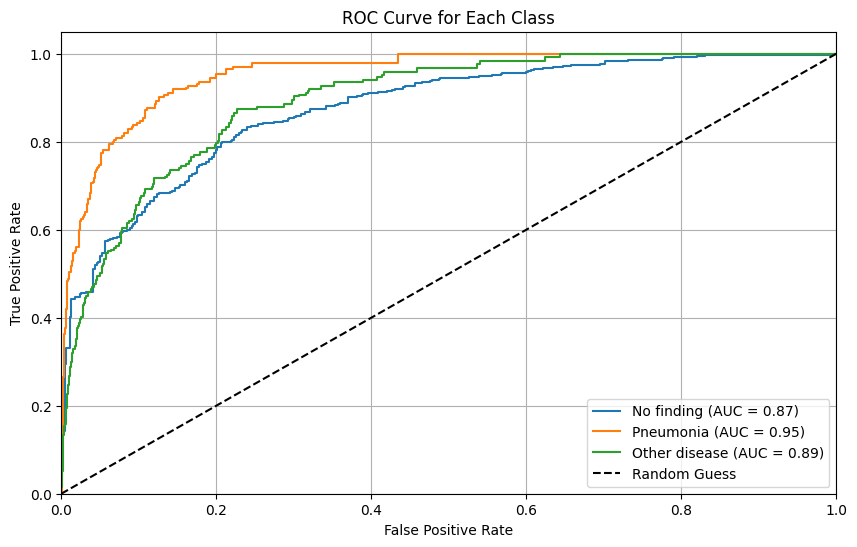

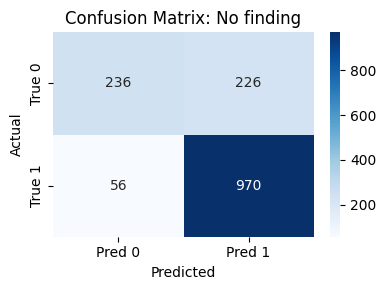

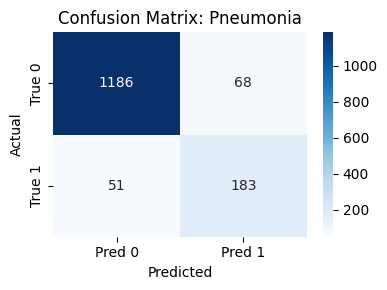

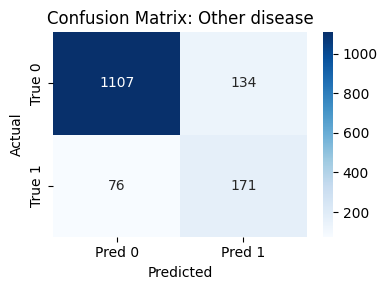

✅ Accuracy for No finding: 0.8105
✅ Accuracy for Pneumonia: 0.9200
✅ Accuracy for Other disease: 0.8589
✅ Overall Label Accuracy: 0.8631


In [21]:
import numpy as np
from sklearn.metrics import precision_recall_curve, classification_report, roc_auc_score, hamming_loss, multilabel_confusion_matrix

# CLASS_NAMES used in your model
CLASS_NAMES = ["No finding", "Pneumonia", "Other disease"]

# ------------------------
# Step 1: Collect Predictions and True Labels
# ------------------------
y_true = []
y_pred = []

# Use this to prevent infinite looping due to .repeat()
eval_steps = validation_steps  # same as used during model.fit()

for step, (images, labels) in enumerate(val_dataset):
    if step >= eval_steps:
        break
    preds = model.predict(images, verbose=0)
    y_true.extend(labels.numpy())
    y_pred.extend(preds)

y_true = np.array(y_true)
y_pred = np.array(y_pred)

print("✅ Collected predictions and labels")

# ------------------------
# Step 2: Tune optimal thresholds per class using F1
# ------------------------
optimal_thresholds = []

print("\n🔍 Optimal Thresholds (per class):")
for i, class_name in enumerate(CLASS_NAMES):
    precision, recall, thresholds = precision_recall_curve(y_true[:, i], y_pred[:, i])
    f1_scores = 2 * precision * recall / (precision + recall + 1e-6)
    best_thresh = thresholds[np.argmax(f1_scores)]
    optimal_thresholds.append(best_thresh)
    print(f"  {class_name}: Best threshold = {best_thresh:.2f}")

# ------------------------
# Step 3: Apply thresholds and binarize predictions
# ------------------------
y_pred_bin = np.array([
    [1 if p >= t else 0 for p, t in zip(sample, optimal_thresholds)]
    for sample in y_pred
])

# ------------------------
# Step 4: Print Evaluation Metrics
# ------------------------

# Classification report
print("\n📋 Classification Report:")
print(classification_report(y_true, y_pred_bin, target_names=CLASS_NAMES))

# AUC Scores
print("\n📈 AUC Scores (per class):")
for i, class_name in enumerate(CLASS_NAMES):
    auc = roc_auc_score(y_true[:, i], y_pred[:, i])
    print(f"  {class_name}: AUC = {auc:.4f}")

# Hamming Loss
print("\n🧮 Hamming Loss:", hamming_loss(y_true, y_pred_bin))

# # Confusion Matrices
# print("\n🧾 Confusion Matrix (per class):")
# conf_matrices = multilabel_confusion_matrix(y_true, y_pred_bin)
# for i, class_name in enumerate(CLASS_NAMES):
#     print(f"\n{class_name}:\n{conf_matrices[i]}")


import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

plt.figure(figsize=(10, 6))

for i, class_name in enumerate(CLASS_NAMES):
    fpr, tpr, _ = roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{class_name} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Each Class")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()
import seaborn as sns
from sklearn.metrics import multilabel_confusion_matrix

conf_matrices = multilabel_confusion_matrix(y_true, y_pred_bin)

for i, class_name in enumerate(CLASS_NAMES):
    cm = conf_matrices[i]
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Pred 0", "Pred 1"], yticklabels=["True 0", "True 1"])
    plt.title(f"Confusion Matrix: {class_name}")
    plt.ylabel("Actual")
    plt.xlabel("Predicted")
    plt.tight_layout()
    plt.show()


per_class_acc = (y_true == y_pred_bin).sum(axis=0) / y_true.shape[0]
for i, class_name in enumerate(CLASS_NAMES):
    print(f"✅ Accuracy for {class_name}: {per_class_acc[i]:.4f}")


overall_label_acc = (y_true == y_pred_bin).mean()
print(f"✅ Overall Label Accuracy: {overall_label_acc:.4f}")


C:\Users\bisma\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\models\functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor_430']]
Received: inputs=['Tensor(shape=(1, 224, 224, 3))']
  warnings.warn(msg)


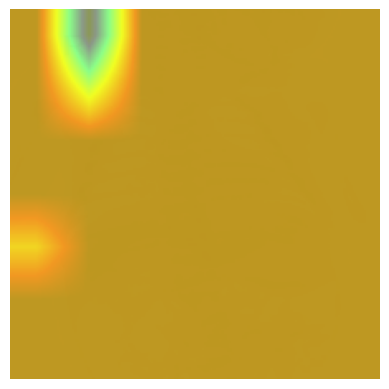

In [22]:
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
import cv2

def get_img_array(img_path):
    img = load_dicom_image(img_path)  # Your existing function
    return tf.expand_dims(img, axis=0)

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, class_index):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, class_index]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def show_heatmap_on_image(img, heatmap, alpha=0.4):
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap_color = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    overlayed = cv2.addWeighted(np.uint8(img * 255), 1 - alpha, heatmap_color, alpha, 0)
    plt.imshow(overlayed)
    plt.axis('off')
    plt.show()

# Example usage
sample_id = val_data.iloc[0]['image_id']
sample_path = os.path.join(path, f"{sample_id}.dicom")
img_array = get_img_array(sample_path)
heatmap = make_gradcam_heatmap(img_array, model, 'conv5_block16_2_conv', class_index=1)  # e.g., Pneumonia class
img = load_dicom_image(sample_path).numpy()
show_heatmap_on_image(img, heatmap)


C:\Users\bisma\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\models\functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor_430']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


✅ Saved Grad-CAM visualization for class 'No finding' at: gradcam_outputs\25b6d85b22af35987df7b4bfd766fbba_class0_No finding.png
✅ Saved Grad-CAM visualization for class 'Pneumonia' at: gradcam_outputs\25b6d85b22af35987df7b4bfd766fbba_class1_Pneumonia.png
✅ Saved Grad-CAM visualization for class 'Other disease' at: gradcam_outputs\25b6d85b22af35987df7b4bfd766fbba_class2_Other disease.png
✅ Saved Grad-CAM visualization for class 'No finding' at: gradcam_outputs\b3660ac23fdec01c685a104d80d39dc7_class0_No finding.png
✅ Saved Grad-CAM visualization for class 'Pneumonia' at: gradcam_outputs\b3660ac23fdec01c685a104d80d39dc7_class1_Pneumonia.png
✅ Saved Grad-CAM visualization for class 'Other disease' at: gradcam_outputs\b3660ac23fdec01c685a104d80d39dc7_class2_Other disease.png
✅ Saved Grad-CAM visualization for class 'No finding' at: gradcam_outputs\d884e38f6f38f00528782ed6c19a1034_class0_No finding.png
✅ Saved Grad-CAM visualization for class 'Pneumonia' at: gradcam_outputs\d884e38f6f38f005

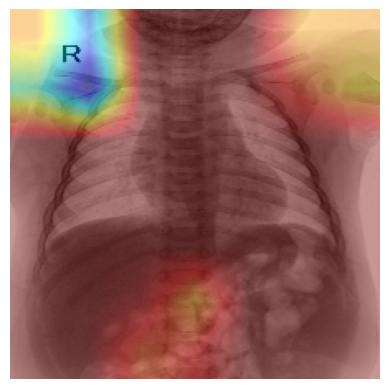

In [25]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut

# Replace this with your actual class order
CLASS_NAMES = ["No finding", "Pneumonia", "Other disease"]
path = 'D:\\xray file\\vindr-pcxr-an-open-large-scale-pediatric-chest-x-ray-dataset-for-interpretation-of-common-thoracic-diseases-1.0.0\\train'

# 1. Load original image for visualization (no preprocessing)
def load_raw_dicom_image(path, img_size=(224, 224)):
    dicom = pydicom.dcmread(path)
    img = apply_voi_lut(dicom.pixel_array, dicom)
    img = img.astype(np.float32)
    img = (img - np.min(img)) / (np.max(img) - np.min(img))
    img = np.stack([img] * 3, axis=-1)
    img = tf.image.resize(img, img_size)
    return img.numpy()

# 2. Load preprocessed image for model prediction
def load_preprocessed_image(path, img_size=(224, 224)):
    from tensorflow.keras.applications.densenet import preprocess_input
    img = load_raw_dicom_image(path, img_size)
    return preprocess_input(img)

# 3. Generate Grad-CAM heatmap
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, class_index):
    grad_model = tf.keras.models.Model(
        [model.inputs], 
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, class_index]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# 4. Overlay heatmap on original image and save/show
def show_heatmap_on_image(img, heatmap, alpha=0.4, save_path=None):
    if np.max(img) <= 1.0:
        img = (img * 255).astype(np.uint8)

    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap_color = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    overlayed = cv2.addWeighted(img, 1 - alpha, heatmap_color, alpha, 0)
    
    plt.imshow(overlayed)
    plt.axis('off')
    
    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
    else:
        plt.show()

# 5. Full Grad-CAM inference + visualization for one image and class
def run_gradcam(image_id, model, target_class_index=1, last_conv_layer_name='conv5_block16_2_conv', save_dir="gradcam_outputs"):
    os.makedirs(save_dir, exist_ok=True)

    dicom_path = os.path.join(path, f"{image_id}.dicom")
    raw_img = load_raw_dicom_image(dicom_path)
    preprocessed_img = load_preprocessed_image(dicom_path)
    img_array = np.expand_dims(preprocessed_img, axis=0)

    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name, class_index=target_class_index)

    filename = f"{image_id}_class{target_class_index}_{CLASS_NAMES[target_class_index]}.png"
    save_path = os.path.join(save_dir, filename)
    show_heatmap_on_image(raw_img, heatmap, save_path=save_path)

    print(f"✅ Saved Grad-CAM visualization for class '{CLASS_NAMES[target_class_index]}' at: {save_path}")
# Example: visualize Grad-CAM for first 3 samples in validation set
for i in range(3):
    image_id = val_data.iloc[i]['image_id']
    
    for class_idx in range(len(CLASS_NAMES)):
        run_gradcam(
            image_id=image_id,
            model=model,
            target_class_index=class_idx,
            last_conv_layer_name='conv5_block16_2_conv'  # ✅ Verify with model.summary()
        )
